# 03 — Baseline Backtest (Opening Range Strategy)

**Goal of Notebook 3:** turn the audited days from `valid_days.csv` into a clean, reproducible **baseline backtest**:
- One decision per day at **10:22** based on **Opening Range 09:30–10:00 (inclusive)**:
  - **Long** if price is in the **top 35%** of OR
  - **Short** if in the **bottom 35%**
  - **No trade** otherwise
- **Risk:** SL = 25 pts, TP = 75 pts, **forced exit at 12:00**.
- **One trade max per day**.
- Compute P&L in **points**, then convert to **$** via config `point_value_usd`.  
- No slippage/fees at first (we’ll add them later as toggles).

## 3.1 — Baseline Backtest: scope & inputs (read-first)

**This section (3.1) just:**
1) Loads config + `valid_days.csv` (from Notebook 2).  
2) Prepares a map from **year → raw CSV path** to quickly fetch minute bars per day.  
3) Shows a tiny summary so we know how many days will be simulated.

Next section (3.2): we’ll implement a **small loader** that returns the **09:30–12:00** minute bars for a single date, ready for the trade logic.


## What to expect
- Audience: market/finance readers who want the baseline OR backtest without digging into code.
- Inputs: `valid_days.csv` from Notebook 2, configs in `config/*.yml`, minute data in `data/raw/`.
- Outputs: `backtest_daily.csv` (per-day results), equity curves, and headline KPIs (win rate, PF, expectancy, drawdown).
- Flow: load configs → sample a day → run full batch → compute KPIs → add costs/sensitivity.
- You don’t edit parameters here; change the YAML files if needed and rerun.


## Inputs & outputs (at a glance)
- **Inputs:**
  - `config/strategy.yml` (zones %, SL/TP, costs toggles)
  - `config/instruments.yml` (session times, point value, tick size, data format)
  - `reports/tables/valid_days.csv` (tradable dates from Notebook 2)
  - `data/raw/*.csv` (minute bars)
- **Outputs saved:**
  - `reports/tables/backtest_daily.csv` (gross) and `backtest_daily_net.csv` (after costs)
  - `reports/tables/backtest_summary.csv` (headline stats, added below)
  - Figures: equity, P&L distributions, monthly heatmap, cost grids (in `reports/figures/`)


In [33]:
# 3.1 — Load config, audited days, and wire up file references

from pathlib import Path
import pandas as pd
import yaml

# --- Paths (works whether you're inside notebooks/ or repo root) ---
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
CONFIG_DIR = ROOT / "config"
DATA_RAW_DIR = ROOT / "data" / "raw"
REPORTS_TBLS = ROOT / "reports" / "tables"

# --- Configs (single source of truth) ---
def load_yaml(p: Path):
    with open(p, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

STRATEGY = load_yaml(CONFIG_DIR / "strategy.yml")
INSTR    = load_yaml(CONFIG_DIR / "instruments.yml")

# Frequently-used fields
session   = INSTR.get("session", {})
market    = INSTR.get("market", {})
costs     = INSTR.get("costs", {})
data_cfg  = INSTR.get("data", {})
params    = STRATEGY.get("parameters", {})

OR_START  = session.get("or_window", {}).get("start", "09:30")
OR_END    = session.get("or_window", {}).get("end_inclusive", "10:00")  # inclusive
ENTRY_T   = session.get("entry_time", "10:22")
EXIT_T    = session.get("hard_exit_time", "12:00")

TOP_PCT   = params.get("zones", {}).get("top_pct", 0.35)
BOT_PCT   = params.get("zones", {}).get("bottom_pct", 0.35)
SL_PTS    = params.get("risk", {}).get("stop_loss_points", 25)
TP_PTS    = params.get("risk", {}).get("take_profit_points", 75)
POINT_VAL = market.get("point_value_usd", 80.0)

# --- Audited trading days from Notebook 2 ---
valid_path = REPORTS_TBLS / "valid_days.csv"
valid_days = pd.read_csv(valid_path, parse_dates=["date"])
valid_days = valid_days.sort_values("date").reset_index(drop=True)

# --- Map year -> raw CSV path (assumes one file per year, like your current naming) ---
year_files = {}
for p in sorted(DATA_RAW_DIR.glob("*.csv")):
    # find a year token in filename
    y = None
    for token in ["2020","2021","2022","2023","2024","2019"]:
        if token in p.name:
            y = int(token)
            break
    if y:
        year_files[y] = p

# --- Tiny summary so we know our inputs are sane ---
summary = pd.DataFrame.from_dict({
    "valid_days_count": [len(valid_days)],
    "years_present":    [sorted(valid_days["date"].dt.year.unique().tolist())],
    "entry_time":       [ENTRY_T],
    "exit_time":        [EXIT_T],
    "or_window":        [f"{OR_START}–{OR_END} (incl)"],
    "zones(top/bot)":   [f"{TOP_PCT:.2f}/{BOT_PCT:.2f}"],
    "risk(SL/TP pts)":  [f"{SL_PTS}/{TP_PTS}"],
    "$ per point":      [POINT_VAL],
})

print("ROOT:", ROOT)
print("Raw files found by year:")
for y in sorted(year_files):
    print(f"  {y}: {year_files[y].name}")

display(summary.head(1))
display(valid_days.head(5))


ROOT: d:\Projects\OpeningRange
Raw files found by year:
  2020: DAT_ASCII_NSXUSD_M1_2020.csv
  2021: DAT_ASCII_NSXUSD_M1_2021.csv
  2022: DAT_ASCII_NSXUSD_M1_2022.csv
  2023: DAT_ASCII_NSXUSD_M1_2023.csv


,valid_days_count,years_present,entry_time,exit_time,or_window,zones(top/bot),risk(SL/TP pts),$ per point
0,902,"[2020, 2021, 2022, 2023]",10:22,12:00,09:30–10:00 (incl),0.35/0.35,25/75,80.0


,file,date,or_count,or_high,or_low,or_range,trade_count,expected_trade_minutes,missing_minutes,duplicate_minutes,has_entry_1022,has_exit_1200
0,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-03,31,8822.17,8752.10,70.07,151,151,0,0,True,True
1,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-06,31,8783.99,8712.49,71.50,151,151,0,0,True,True
2,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-07,31,8859.59,8816.84,42.75,151,151,0,0,True,True
3,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-08,31,8879.50,8831.97,47.53,151,151,0,0,True,True
4,DAT_ASCII_NSXUSD_M1_2020.csv,2020-01-09,31,9003.51,8977.64,25.87,151,151,0,0,True,True


### 3.2 — Day loader (returns 09:30–12:00 window and OR slice for a given date)
**What this does:**  
Given a date like `YYYY-MM-DD`, it:
1) Finds the correct year CSV in `data/raw/`.  
2) Parses timestamps (assumes NY local unless `source_timezone` is set).  
3) Slices the **Opening Range** (09:30–10:00 inclusive) and the **trade window** (09:30–12:00 inclusive).  
4) Computes quick QC (missing/duplicate minutes, OR stats, 10:22/12:00 present).  
5) Returns:
   - `win` → DataFrame for **09:30–12:00** (1-min OHLC),
   - `or_slice` → DataFrame for **09:30–10:00**,
   - `qc` → dict with checks and OR stats.

> **How to use (after running the cell):**  
> `win, or_slice, qc = load_day_window("2020-01-03")`


In [52]:
# 3.2 — Day window extraction & quality checks

import sys
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Import the core (no heavy work here)
from src import or_core
or_core.PREVIEW = False  # keep outputs quiet by default

from src.or_core import load_day_window

# Choose a lightweight example date (you can change it anytime)
EXAMPLE_DATE = "2020-01-03"

# Load windows + quick QC dictionary
win, or_slice, qc = load_day_window(EXAMPLE_DATE)

# Minimal feedback (one-liners)
print(f"[{EXAMPLE_DATE}] OR rows={len(or_slice)} | WIN rows={len(win)}")
print("QC:", {k: qc[k] for k in ["missing_minutes","duplicate_minutes","has_entry_1022","has_exit_1200","or_high","or_low","or_range"]})


[2020-01-03] OR rows=31 | WIN rows=151
QC: {'missing_minutes': 0, 'duplicate_minutes': 0, 'has_entry_1022': True, 'has_exit_1200': True, 'or_high': 8822.17, 'or_low': 8752.1, 'or_range': 70.06999999999971}


d:\Projects\OpeningRange\src\or_core.py:102: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return pd.date_range(start=start, end=end, freq="T", tz=NY)


### 3.3 — Signal & barrier levels for one day (deterministic entry at 10:22)

**What this does (read-first):**
- Input: a trading **date** (e.g., `"2020-01-03"`).
- Uses the day loader (3.2) to get:
  - **OR slice** = 09:30–10:00 (inclusive)
  - **Trade window** = 09:30–12:00 (inclusive)
  - **QC** checks
- Computes:
  - `OR_high`, `OR_low`, `OR_range`
  - **Bottom-35% cutoff** = `OR_low + 0.35 * OR_range`
  - **Top-35% cutoff**    = `OR_high − 0.35 * OR_range`
  - **10:22 close** (`P_10:22`)
  - **Decision**: Long / Short / No trade
  - **Barriers** from entry `E = P_10:22`:
    - Long: `SL = E − 25`, `TP = E + 75`
    - Short: `SL = E + 25`, `TP = E − 75`
- Returns a small **summary dict** and shows a neat, human-readable table.

> Note: This cell **only sets the signal & barriers**. The minute-by-minute execution (TP/SL/12:00) comes next (3.4).


In [35]:
# 3.3 — Signal logic at 10:22

from src.or_core import DaySignal, compute_signal_for_date

sig = compute_signal_for_date(EXAMPLE_DATE, win=win, or_slice=or_slice, qc=qc)

# Minimal feedback (single line)
print(f"[{sig.date}] decision={sig.decision} | entry={sig.entry_price} @ {sig.entry_time} "
      f"| SL={sig.sl} TP={sig.tp} | OR[{sig.or_low}, {sig.or_high}] rng={sig.or_range}")


[2020-01-03] decision=long | entry=8798.09 @ 10:22 | SL=8773.09 TP=8873.09 | OR[8752.1, 8822.17] rng=70.06999999999971


In [36]:
# Example (you can change the date):
sig = compute_signal_for_date("2020-01-03")
sig


DaySignal(date='2020-01-03', decision='long', entry_time='10:22', entry_price=8798.09, sl=8773.09, tp=8873.09, or_high=8822.17, or_low=8752.1, or_range=70.06999999999971, top_cutoff=8797.6455, bottom_cutoff=8776.6245, has_1022=True, has_1200=True, notes='OK')

### 3.4 — Single-day execution (10:22 → 12:00): TP/SL/Hard-exit

**What this does (read-first):**
- Takes a `date` (e.g., `"2020-01-03"`).
- Uses **3.2** (loader) and **3.3** (signal) to get entry `E`, `SL`, `TP`.
- Walks minute-by-minute **from 10:23 to 12:00** (we enter at **10:22 close**, so checks start on the **next bar**).
- Detects barrier touches using **bar high/low** (more realistic than close-only).

**Tie-break rule (if a single bar could hit both SL and TP):**
- **Conservative “worse-first”**: count it as **SL** (for long: low≤SL and high≥TP ⇒ SL; for short: high≥SL and low≤TP ⇒ SL).

**Outputs:**
- A small summary table with `exit_time`, `exit_price`, `exit_reason` (`tp` / `sl` / `time`), `PnL_pts`, and `PnL_usd` using your config `$ per point` (and `position_size` if set; default 1).


In [37]:
# 3.4 — Execution engine: path simulation + P&L

from src.or_core import DayExecution, execute_day

ex = execute_day(EXAMPLE_DATE)

# Minimal feedback (single line)
fmt_pts = f"{ex.pnl_pts:.2f}" if ex.pnl_pts is not None else "None"
fmt_usd = f"{ex.pnl_usd:.2f}" if ex.pnl_usd is not None else "None"
print(f"[{ex.date}] {ex.decision} | entry={ex.entry_price} @ {ex.entry_time} "
      f"-> exit={ex.exit_price} @ {ex.exit_time} ({ex.exit_reason}) | pnl_pts={fmt_pts} | pnl_usd={fmt_usd}")


[2020-01-03] long | entry=8798.09 @ 10:22 -> exit=8820.81 @ 12:00:00 (time) | pnl_pts=22.72 | pnl_usd=1817.60


In [38]:
# Example run (you can change the date):
ex = execute_day("2020-01-03")
ex


DayExecution(date='2020-01-03', decision='long', entry_time='10:22', entry_price=8798.09, sl=8773.09, tp=8873.09, exit_time='12:00:00', exit_price=8820.81, exit_reason='time', pnl_pts=22.719999999999345, pnl_usd=1817.5999999999476, notes='Conservative tie-break; checks start after entry bar.')

### 3.5 — Batch backtest over all valid days (strict mode)

**What this does (read-first):**
- Iterates **only** the dates in `valid_days.csv` (the audited, tradable set).
- For each date: calls **3.3** (signal) + **3.4** (execution) to get `exit_reason`, `PnL_pts`, `PnL_usd`, etc.
- Aggregates daily results; computes:
  - #days simulated, #signals long/short, #no-trade
  - #trades executed (long/short only), wins, losses, **win rate**
  - Sum of **PnL (pts)** and **PnL ($)**
  - **Equity curve** (using `initial_capital`), **Max Drawdown** (absolute & %)
- Saves a CSV (`reports/tables/backtest_daily.csv`) for reproducibility.

> Notes:
> - A “trade” is a day with **decision in {long, short}**. “none” are counted separately.
> - Profit is in **points**, then converted to **$** with your config’s `point_value_usd × position_size`.
> - Equity = `initial_capital + cumulative PnL ($)`.


Backtesting valid days: 100%|██████████| 902/902 [00:07<00:00, 120.97day/s]

Saved daily results to: d:\Projects\OpeningRange\reports\tables\backtest_daily.csv


,value
days_simulated,902.00
trades_executed,740.00
no_trade_days,162.00
wins,274.00
losses,466.00
flats,0.00
winrate_%,37.03
sum_pnl_pts,4188.79
sum_pnl_usd,335103.20
initial_capital,100000.00


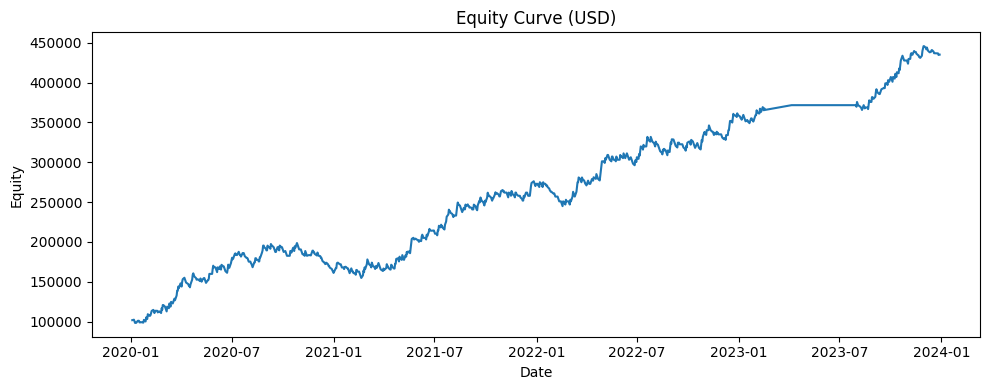

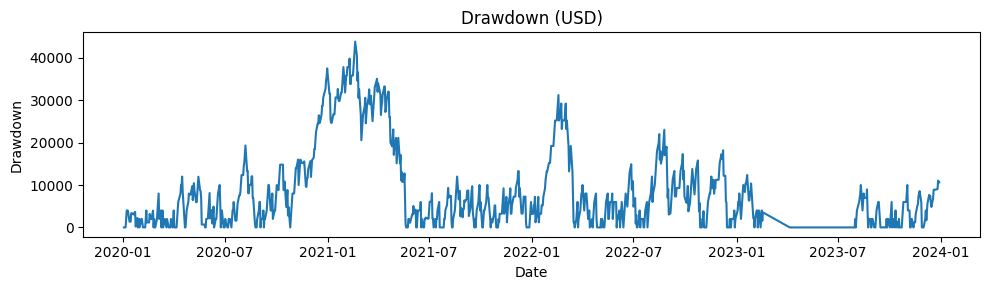

,date,decision,entry_time,entry_price,SL,TP,exit_time,exit_price,exit_reason,pnl_pts,pnl_usd,notes,pnl_usd_filled,equity,equity_peak,drawdown,year,month,equity_shift
0,2020-01-03,long,10:22,8798.09,8773.09,8873.09,12:00:00,8820.81,time,22.72,1817.6,Conservative tie-break; checks start after ent...,1817.6,101817.6,101817.6,0.0,2020,1,100000.0
1,2020-01-06,long,10:22,8798.25,8773.25,8873.25,12:00:00,8805.49,time,7.24,579.2,Conservative tie-break; checks start after ent...,579.2,102396.8,102396.8,0.0,2020,1,101817.6
2,2020-01-07,long,10:22,8852.84,8827.84,8927.84,10:32:00,8827.84,sl,-25.00,-2000.0,Conservative tie-break; checks start after ent...,-2000.0,100396.8,102396.8,2000.0,2020,1,102396.8
3,2020-01-08,long,10:22,8871.60,8846.60,8946.60,10:48:00,8846.60,sl,-25.00,-2000.0,Conservative tie-break; checks start after ent...,-2000.0,98396.8,102396.8,4000.0,2020,1,100396.8
4,2020-01-09,none,10:22,8989.72,NaN,NaN,10:22,8989.72,no_trade,0.00,0.0,Middle zone at 10:22; no position.,0.0,98396.8,102396.8,4000.0,2020,1,98396.8
5,2020-01-10,none,10:22,9011.06,NaN,NaN,10:22,9011.06,no_trade,0.00,0.0,Middle zone at 10:22; no position.,0.0,98396.8,102396.8,4000.0,2020,1,98396.8
6,2020-01-13,long,10:22,9010.79,8985.79,9085.79,12:00:00,9043.90,time,33.11,2648.8,Conservative tie-break; checks start after ent...,2648.8,101045.6,102396.8,1351.2,2020,1,98396.8
7,2020-01-14,none,10:22,9050.90,NaN,NaN,10:22,9050.90,no_trade,0.00,0.0,Middle zone at 10:22; no position.,0.0,101045.6,102396.8,1351.2,2020,1,101045.6
8,2020-01-15,long,10:22,9061.09,9036.09,9136.09,12:00:00,9060.88,time,-0.21,-16.8,Conservative tie-break; checks start after ent...,-16.8,101028.8,102396.8,1368.0,2020,1,101045.6
9,2020-01-16,long,10:22,9092.31,9067.31,9167.31,11:16:00,9067.31,sl,-25.00,-2000.0,Conservative tie-break; checks start after ent...,-2000.0,99028.8,102396.8,3368.0,2020,1,101028.8


,year,month,days,trades,pnl_usd,eq_start,eq_end,ret_pct
0,2020,1,21,15,9282.40,100000.00,109282.40,9.282400
1,2020,2,20,15,11508.80,109282.40,120791.20,10.531247
2,2020,3,20,19,25204.80,120791.20,145996.00,20.866421
3,2020,4,21,19,6867.20,145996.00,152863.20,4.703691
4,2020,5,21,16,15331.20,152863.20,168194.40,10.029360
5,2020,6,22,21,8836.00,168194.40,177030.40,5.253445
6,2020,7,23,18,-1749.60,177030.40,175280.80,-0.988305
7,2020,8,21,15,16127.20,175280.80,191408.00,9.200780
8,2020,9,22,16,0.00,191408.00,191408.00,0.000000
9,2020,10,22,18,-806.40,191408.00,190601.60,-0.421299


In [39]:
# 3.5 — Batch backtest

from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from contextlib import contextmanager, redirect_stdout, redirect_stderr
import io, IPython.display as ipd

# --- Paths
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables"
REPORTS_TBLS.mkdir(parents=True, exist_ok=True)

# --- Load audited days
valid_path = REPORTS_TBLS / "valid_days.csv"
if "valid_days" in globals():
    vd = valid_days.copy()
else:
    vd = pd.read_csv(valid_path, parse_dates=["date"])
vd = vd.sort_values("date").reset_index(drop=True)

# --- Pull config values (with safe fallbacks)
try:
    init_capital = STRATEGY.get("reporting", {}).get("initial_capital", 100_000)
except Exception:
    init_capital = 100_000
try:
    point_val = INSTR["market"]["point_value_usd"]
except Exception:
    point_val = 80.0
try:
    pos_size = INSTR["market"].get("position_size", 1.0)
except Exception:
    pos_size = 1.0

# --- Require dependencies from 3.2–3.4
if "execute_day" not in globals():
    raise RuntimeError("Please run sections 3.2, 3.3, and 3.4 first.")

@contextmanager
def mute_everything():
    buf_out, buf_err = io.StringIO(), io.StringIO()
    # Save originals
    orig_ipd_display = ipd.display
    orig_global_display = globals().get("display", None)
    try:
        # Silence any display(...) calls
        ipd.display = lambda *a, **k: None
        if orig_global_display is not None:
            globals()["display"] = lambda *a, **k: None
        # Silence print/stdout/stderr
        with redirect_stdout(buf_out), redirect_stderr(buf_err):
            yield
    finally:
        # Restore
        ipd.display = orig_ipd_display
        if orig_global_display is not None:
            globals()["display"] = orig_global_display


# --- Iterate
dates = vd["date"].dt.strftime("%Y-%m-%d").tolist()
records = []
for d in tqdm(dates, desc="Backtesting valid days", unit="day"):
    with mute_everything():            # <- wraps all nested calls (3.3 + 3.4 + 3.2)
        ex = execute_day(d)
    records.append({
        "date": d,
        "decision": ex.decision,
        "entry_time": ex.entry_time,
        "entry_price": ex.entry_price,
        "SL": ex.sl,
        "TP": ex.tp,
        "exit_time": ex.exit_time,
        "exit_price": ex.exit_price,
        "exit_reason": ex.exit_reason,
        "pnl_pts": ex.pnl_pts,
        "pnl_usd": ex.pnl_usd,
        "notes": ex.notes,
    })

bt = pd.DataFrame.from_records(records)
bt["date"] = pd.to_datetime(bt["date"])

# --- Save raw daily results
bt_path = REPORTS_TBLS / "backtest_daily.csv"
bt.sort_values("date").to_csv(bt_path, index=False)

# --- KPIs
is_trade   = bt["decision"].isin(["long","short"])
trades     = bt[is_trade].copy()
wins       = trades["pnl_pts"] > 0
losses     = trades["pnl_pts"] < 0
n_days     = len(bt)
n_trades   = int(is_trade.sum())
n_wins     = int(wins.sum())
n_losses   = int(losses.sum())
n_flat     = int((trades["pnl_pts"] == 0).sum())
n_none     = int((bt["decision"] == "none").sum())
winrate    = (n_wins / n_trades * 100.0) if n_trades > 0 else 0.0

sum_pts    = float(trades["pnl_pts"].sum())
sum_usd    = float(trades["pnl_usd"].sum())

# --- Equity & drawdown (USD)
bt["pnl_usd_filled"] = bt["pnl_usd"].fillna(0.0)
bt["equity"] = init_capital + bt.sort_values("date")["pnl_usd_filled"].cumsum()
bt["equity_peak"] = bt["equity"].cummax()
bt["drawdown"] = bt["equity_peak"] - bt["equity"]
max_dd = float(bt["drawdown"].max())
max_dd_pct = float(max_dd / bt["equity_peak"].max() * 100.0) if bt["equity_peak"].max() > 0 else 0.0

# --- Small monthly summary (USD)
bt["year"] = bt["date"].dt.year
bt["month"] = bt["date"].dt.month
monthly = bt.groupby(["year","month"]).agg(
    days=("date","count"),
    trades=("decision", lambda s: int(s.isin(["long","short"]).sum())),
    pnl_usd=("pnl_usd_filled","sum"),
)
# monthly return uses equity Δ within month
bt["equity_shift"] = bt["equity"].shift(1).fillna(init_capital)
bt_month = bt.groupby(["year","month"]).agg(
    eq_start=("equity_shift","first"),
    eq_end=("equity","last")
)
bt_month["ret_pct"] = np.where(
    bt_month["eq_start"] > 0,
    100.0 * (bt_month["eq_end"] - bt_month["eq_start"]) / bt_month["eq_start"],
    np.nan
)
monthly = monthly.join(bt_month, how="left")

# --- Summary table
summary = pd.DataFrame({
    "days_simulated":         [n_days],
    "trades_executed":        [n_trades],
    "no_trade_days":          [n_none],
    "wins":                   [n_wins],
    "losses":                 [n_losses],
    "flats":                  [n_flat],
    "winrate_%":              [round(winrate, 2)],
    "sum_pnl_pts":            [round(sum_pts, 2)],
    "sum_pnl_usd":            [round(sum_usd, 2)],
    "initial_capital":        [init_capital],
    "final_equity":           [round(float(bt['equity'].iloc[-1]) if len(bt) else init_capital, 2)],
    "max_drawdown_usd":       [round(max_dd, 2)],
    "max_drawdown_pct":       [round(max_dd_pct, 2)],
    "point_value_usd":        [point_val],
    "position_size":          [pos_size],
}).T.rename(columns={0:"value"})

print("Saved daily results to:", bt_path)
display(summary)

# --- Quick visuals: Equity + Drawdown
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(bt["date"], bt["equity"])
plt.title("Equity Curve (USD)")
plt.xlabel("Date"); plt.ylabel("Equity")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(bt["date"], bt["drawdown"])
plt.title("Drawdown (USD)")
plt.xlabel("Date"); plt.ylabel("Drawdown")
plt.tight_layout(); plt.show()

# Peek at daily trades
display(bt.head(10).sort_values("date").reset_index(drop=True))
display(monthly.reset_index().sort_values(["year","month"]))


In [ ]:
# 3.5A — Backtest at-a-glance (populate after 3.5 runs)
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
REPORTS_TBLS = ROOT / "reports" / "tables"
path_bt = REPORTS_TBLS / "backtest_daily.csv"

bt = globals().get("bt")
if bt is None and path_bt.exists():
    bt = pd.read_csv(path_bt, parse_dates=["date"])

if bt is None or bt.empty:
    print("Run 3.5 to generate bt (backtest_daily.csv) first.")
else:
    trades = bt[bt["decision"].isin(["long","short"])]
    wins = trades[trades["pnl_usd"] > 0]
    losses = trades[trades["pnl_usd"] < 0]
    no_trades = bt[bt["decision"] == "none"]

    pf = wins["pnl_usd"].sum() / abs(losses["pnl_usd"].sum()) if not losses.empty else float("inf")
    payoff = wins["pnl_usd"].mean() / abs(losses["pnl_usd"].mean()) if (not wins.empty and not losses.empty) else None
    expectancy = trades["pnl_usd"].mean() if not trades.empty else None

    summary = {
        "days_simulated": len(bt),
        "trades_executed": len(trades),
        "no_trade_days": len(no_trades),
        "win_rate": round(len(wins) / len(trades) * 100, 2) if len(trades) else None,
        "profit_factor": round(pf, 3) if pf not in [float("inf"), None] else pf,
        "payoff_ratio": round(payoff, 3) if payoff is not None else None,
        "expectancy_usd": round(expectancy, 2) if expectancy is not None else None,
        "avg_hold_minutes": round(trades["hold_minutes"].mean(), 1) if "hold_minutes" in trades else None,
        "final_equity": round(bt.get("equity", pd.Series()).iloc[-1], 2) if "equity" in bt else None,
        "max_drawdown_usd": round(bt.get("dd", pd.Series()).min(), 2) if "dd" in bt else None,
    }
    ser = pd.Series(summary, name="baseline_summary")
    display(ser)

    out_path = REPORTS_TBLS / "backtest_summary.csv"
    ser.to_csv(out_path)
    print("Saved ->", out_path)


### 3.6 — Performance report (part 1): payoff, profit factor, expectancy

### 3.6.1 — Why this works: payoff & expectancy

**Goal.** Quantify *why* we profit with a low win rate:
- Average **win** / **loss** ($ and pts)
- **Payoff ratio** (avg win ÷ avg loss)
- **Profit factor** (sum wins ÷ sum losses)
- **Expectancy** per trade (pts and $)
- **CAGR** over the tested period

We’ll use the daily backtest results from 3.5 (`bt`), counting only days where a trade occurred (decision ∈ {long, short}).


In [40]:
# 3.6.1 — Payoff, Profit Factor, Expectancy

import pandas as pd
import numpy as np
from pathlib import Path

# Reuse bt from 3.5 or reload if needed
try:
    bt
except NameError:
    ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
    bt = pd.read_csv(ROOT / "reports" / "tables" / "backtest_daily.csv", parse_dates=["date"])

# Filter to executed trades
trades = bt[bt["decision"].isin(["long","short"])].copy()
wins   = trades[trades["pnl_usd"] > 0]
losses = trades[trades["pnl_usd"] < 0]

# Averages
avg_win_usd  = wins["pnl_usd"].mean()   if len(wins)   else np.nan
avg_loss_usd = -losses["pnl_usd"].mean() if len(losses) else np.nan  # absolute
avg_win_pts  = wins["pnl_pts"].mean()   if len(wins)   else np.nan
avg_loss_pts = -losses["pnl_pts"].mean() if len(losses) else np.nan  # absolute

# Ratios
payoff = (avg_win_usd / avg_loss_usd) if (avg_win_usd and avg_loss_usd) else np.nan
profit_factor = (wins["pnl_usd"].sum() / -losses["pnl_usd"].sum()) if len(losses) else np.nan

# Expectancy
exp_usd = trades["pnl_usd"].mean() if len(trades) else np.nan
exp_pts = trades["pnl_pts"].mean() if len(trades) else np.nan

# CAGR (using equity from 3.5 if present; else recompute)
if "equity" not in bt.columns:
    init_capital = 100_000.0
    bt["pnl_usd_filled"] = bt["pnl_usd"].fillna(0.0)
    bt = bt.sort_values("date")
    bt["equity"] = init_capital + bt["pnl_usd_filled"].cumsum()

start_val = float(bt["equity"].iloc[0])
end_val   = float(bt["equity"].iloc[-1])
years     = (bt["date"].max() - bt["date"].min()).days / 365.25
cagr = (end_val / start_val)**(1/years) - 1 if years > 0 and start_val > 0 else np.nan

# Win-rate on executed trades
winrate = (len(wins) / len(trades) * 100.0) if len(trades) else np.nan

summary_361 = pd.DataFrame({
    "trades_executed": [len(trades)],
    "wins":            [len(wins)],
    "losses":          [len(losses)],
    "winrate_%":       [round(winrate, 2)],
    "avg_win_usd":     [round(avg_win_usd, 2)],
    "avg_loss_usd":    [round(avg_loss_usd, 2)],
    "payoff_ratio":    [round(payoff, 3)],
    "profit_factor":   [round(profit_factor, 3)],
    "expectancy_usd":  [round(exp_usd, 2)],
    "expectancy_pts":  [round(exp_pts, 2)],
    "CAGR_%":          [round(100*cagr, 2)],
}).T.rename(columns={0:"value"})

display(summary_361)


,value
trades_executed,740.000
wins,274.000
losses,466.000
winrate_%,37.030
avg_win_usd,4474.130
avg_loss_usd,1911.610
payoff_ratio,2.341
profit_factor,1.376
expectancy_usd,452.840
expectancy_pts,5.660


### Conclusion — 3.6.1 Payoff & Expectancy

Across **740** executed trades, we won **274** and lost **466**, for a **win rate of \~37%**. That sounds low, but the strategy’s **average win (\$4,474)** is much larger than its **average loss (\$1,912)**, giving a **payoff ratio of \~2.34** (each winner is \~2.3× a loser). Because of that, the **profit factor is 1.38**, meaning the *total* dollars from winners are 1.38× the total dollars from losers; anything above 1.0 indicates a profitable edge. The **expectancy**—the average result per trade—is **\~\$453** (≈ **5.66 points**), so every time this setup triggers, it has historically added about \$453 to equity on average. In other words, **you don’t need a high hit rate if your winners are much bigger than your losers**, which is exactly what the 25-point SL / 75-point TP structure is designed to achieve. Finally, the reported **CAGR (\~44%)** is the *annualized growth rate* implied by the equity curve over the test period (i.e., the steady yearly rate that would compound the starting capital to the ending capital); it’s a backtest summary, **not a guarantee**, and it will change once we include **transaction costs and slippage** (next step). Overall: the stats support a **positive but selective** strategy—few trades become big winners, many become small losses or time-outs, yet the average trade stays positive.


### 3.6.2a — Long vs Short contribution to P&L (cumulative)
**What/why:** Split the P&L into **long-only** and **short-only** streams to see which side of the strategy carries the edge over time.  
**How to read:** Lines show cumulative P&L (USD) contributed by longs vs shorts since the start date.


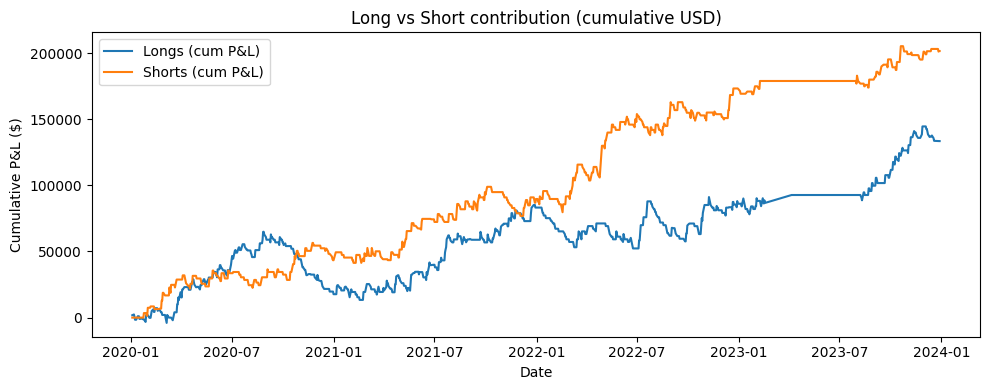

In [41]:
# Reuse bt or reload
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

try:
    bt
except NameError:
    ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
    bt = pd.read_csv(ROOT / "reports" / "tables" / "backtest_daily.csv", parse_dates=["date"])

bt = bt.sort_values("date").copy()
bt["pnl_usd_filled"] = bt["pnl_usd"].fillna(0.0)

pnl_long  = np.where(bt["decision"].eq("long"),  bt["pnl_usd_filled"], 0.0)
pnl_short = np.where(bt["decision"].eq("short"), bt["pnl_usd_filled"], 0.0)

bt["cum_long"]  = pd.Series(pnl_long).cumsum()
bt["cum_short"] = pd.Series(pnl_short).cumsum()

plt.figure(figsize=(10,4))
plt.plot(bt["date"], bt["cum_long"], label="Longs (cum P&L)")
plt.plot(bt["date"], bt["cum_short"], label="Shorts (cum P&L)")
plt.title("Long vs Short contribution (cumulative USD)")
plt.xlabel("Date"); plt.ylabel("Cumulative P&L ($)")
plt.legend(); plt.tight_layout(); plt.show()


### 3.6.2b — Exit reason mix (TP vs SL vs Time)
**What/why:** See how trades usually end: **Take Profit**, **Stop Loss**, or **Time exit @ 12:00**.  
**How to read:** Bars show count of each exit reason across executed trades.


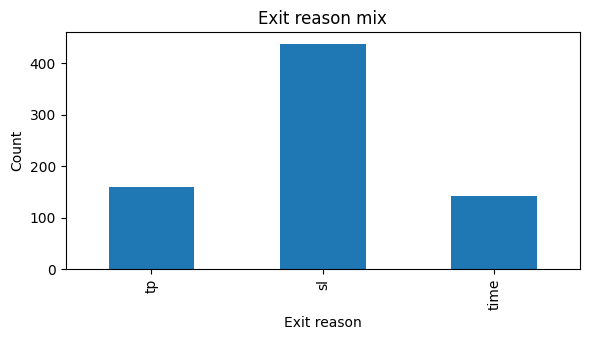

exit_reason,tp,sl,time
count,160,438,142


In [42]:
trades = bt[bt["decision"].isin(["long","short"])].copy()
exit_counts = trades["exit_reason"].value_counts().reindex(["tp","sl","time"], fill_value=0)

plt.figure(figsize=(6,3.5))
exit_counts.plot(kind="bar")
plt.title("Exit reason mix")
plt.xlabel("Exit reason"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# (Optional small table)
display(exit_counts.rename("count").to_frame().T)


### 3.6.2c — Distribution of trade P&L (USD)
**What/why:** Understand the shape of outcomes per trade.  
**How to read:** Histogram of **trade P&L ($)**; vertical lines mark **mean** and **median**.


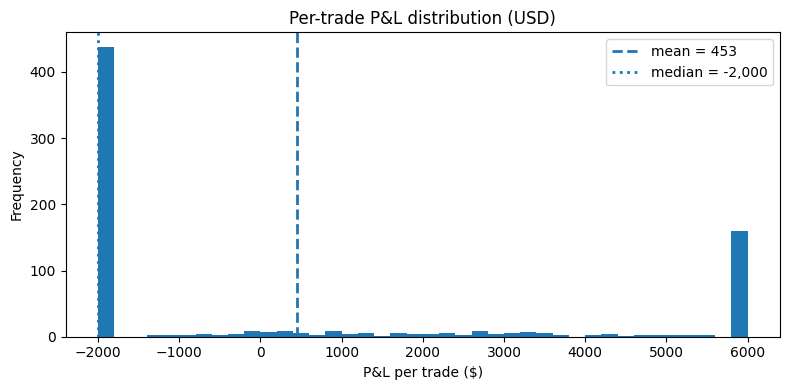

In [43]:
vals = trades["pnl_usd"].astype(float).values
mean_v = np.nanmean(vals)
med_v  = np.nanmedian(vals)

plt.figure(figsize=(8,4))
plt.hist(vals, bins=40)
plt.axvline(mean_v, linestyle="--", linewidth=2, label=f"mean = {mean_v:,.0f}")
plt.axvline(med_v,  linestyle=":",  linewidth=2, label=f"median = {med_v:,.0f}")
plt.title("Per-trade P&L distribution (USD)")
plt.xlabel("P&L per trade ($)"); plt.ylabel("Frequency")
plt.legend(); plt.tight_layout(); plt.show()


### 3.6.2d — Monthly P&L heatmap
**What/why:** Where does the strategy earn/lose by calendar month?  
**How to read:** Each cell = **total P&L ($)** for that Year × Month (darker = stronger).


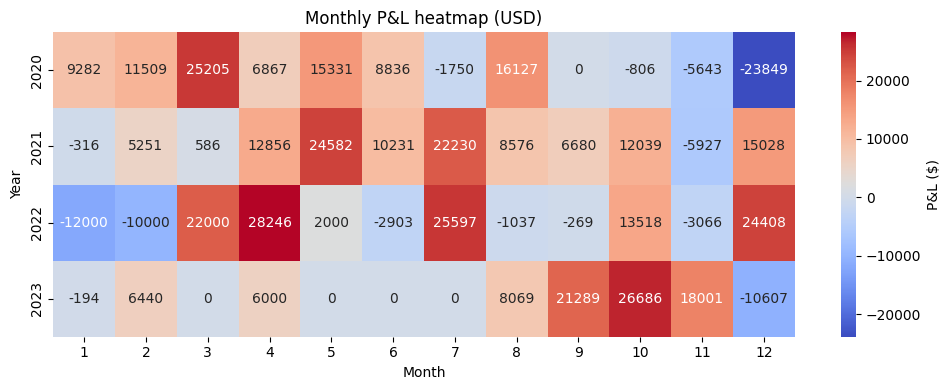

In [44]:
import seaborn as sns

trades["year"]  = trades["date"].dt.year
trades["month"] = trades["date"].dt.month
month_tbl = trades.pivot_table(index="year", columns="month", values="pnl_usd", aggfunc="sum").fillna(0.0)
month_tbl = month_tbl.reindex(columns=range(1,13), fill_value=0.0)  # ensure 1..12

plt.figure(figsize=(10,4))
sns.heatmap(month_tbl, annot=True, fmt=".0f", cmap="coolwarm", cbar_kws={"label": "P&L ($)"})
plt.title("Monthly P&L heatmap (USD)")
plt.xlabel("Month"); plt.ylabel("Year")
plt.tight_layout(); plt.show()


### 3.6.2e — Time-to-exit (minutes from 10:22)
**What/why:** How long do trades typically take to resolve after the 10:22 entry?  
**How it’s computed:** For each executed trade, we parse the `entry_time` and `exit_time`, anchor them on the trade date, and plot the minutes between them.  
**Notes:** Max should be ~98 minutes (10:22 → 12:00). We also show median/mean minutes per exit reason (TP, SL, time).


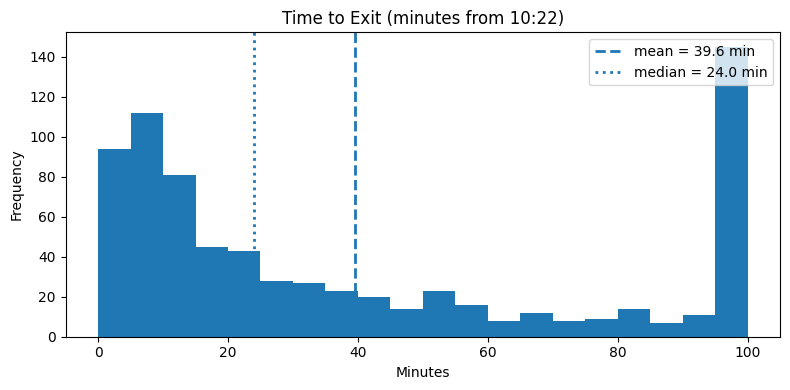

,count,median,mean
exit_reason,,,
tp,160,31.0,39.86
sl,438,11.0,20.61
time,142,98.0,98.00


In [45]:
# 3.6.2e — Time-to-exit distribution

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Reuse bt or reload if needed
try:
    bt
except NameError:
    ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
    bt = pd.read_csv(ROOT / "reports" / "tables" / "backtest_daily.csv", parse_dates=["date"])

trades = bt[bt["decision"].isin(["long","short"])].copy()
trades = trades[trades["exit_time"].notna()].copy()

# Normalize times to HH:MM:SS (strip any timezone offset text if present)
trades["entry_hms"] = trades["entry_time"].astype(str).str[:5] + ":00"   # e.g., "10:22:00"
trades["exit_hms"]  = trades["exit_time"].astype(str).str[:8]            # e.g., "11:37:00"

# Anchor on the trade date (naive local times are fine since both use same day/zone)
base_date = trades["date"].dt.strftime("%Y-%m-%d")
entry_dt  = pd.to_datetime(base_date + " " + trades["entry_hms"], errors="coerce")
exit_dt   = pd.to_datetime(base_date + " " + trades["exit_hms"], errors="coerce")

trades["minutes_to_exit"] = (exit_dt - entry_dt).dt.total_seconds() / 60.0
trades = trades[np.isfinite(trades["minutes_to_exit"]) & (trades["minutes_to_exit"] >= 0)]

# Overall stats
mean_min = trades["minutes_to_exit"].mean()
median_min = trades["minutes_to_exit"].median()

# Plot histogram (5-minute bins up to 100)
bins = np.arange(0, 101, 5)
plt.figure(figsize=(8,4))
plt.hist(trades["minutes_to_exit"], bins=bins)
plt.axvline(mean_min, linestyle="--", linewidth=2, label=f"mean = {mean_min:.1f} min")
plt.axvline(median_min, linestyle=":", linewidth=2, label=f"median = {median_min:.1f} min")
plt.title("Time to Exit (minutes from 10:22)")
plt.xlabel("Minutes"); plt.ylabel("Frequency")
plt.legend(); plt.tight_layout(); plt.show()

# Small table by exit reason
by_reason = (trades.groupby("exit_reason")["minutes_to_exit"]
                    .agg(count="count", median="median", mean="mean")
                    .reindex(["tp","sl","time"]))
display(by_reason.round(2))


### 3.7 — Costs & fills (make results realistic)

#### 3.7.1 — Define the cost model
**Goal.** Add realistic trading frictions:
- **Commission (round trip, USD)** per trade.
- **Spread** + **slippage** in **points** (round trip).  
We’ll read from `strategy.yml` if present (under `costs:`) and fall back to reasonable defaults that you should adjust to your broker/instrument.

**Notes.** Costs are applied **only** on days with a trade (long/short). No-trade days stay 0.


In [46]:
# 3.7.1 — Cost model parameters

# Reuse config / fallbacks
try:
    POINT_VAL = INSTR["market"]["point_value_usd"]
except Exception:
    POINT_VAL = 80.0
try:
    POS_SIZE = INSTR["market"].get("position_size", 1.0)
except Exception:
    POS_SIZE = 1.0

# Pull from strategy.yml if available
def _get_cost(key, default):
    try:
        return float(STRATEGY.get("costs", {}).get(key, default))
    except Exception:
        return float(default)

COSTS = {
    "commission_roundtrip_usd": _get_cost("commission_roundtrip_usd", 0.0),   # e.g. 4.0
    "spread_points_roundtrip":  _get_cost("spread_points_roundtrip",  0.50),   # e.g. 0.50 pt
    "slippage_points_roundtrip":_get_cost("slippage_points_roundtrip",0.25),   # e.g. 0.25 pt
}

print("Cost model (round-trip):", COSTS, "| $/pt:", POINT_VAL, "| size:", POS_SIZE)


Cost model (round-trip): {'commission_roundtrip_usd': 0.0, 'spread_points_roundtrip': 0.5, 'slippage_points_roundtrip': 0.25} | $/pt: 80.0 | size: 1.0


### 3.7.2 — Apply costs to each trade and recompute equity
**What this does.**  
- Converts spread+slippage points to USD: `(spread + slippage) × point_value × position_size`.  
- Adds commission (USD).  
- Subtracts the **total** from each trade’s P&L to get **net** P&L.  
- Rebuilds **net equity** and **net drawdown** time series.

**Saved output.** `reports/tables/backtest_daily_net.csv`


In [47]:
# 3.7.2 — Apply costs → net P&L & net equity

import pandas as pd
from pathlib import Path
import numpy as np

# Reuse bt from 3.5 or reload
try:
    bt
except NameError:
    ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
    bt = pd.read_csv(ROOT / "reports" / "tables" / "backtest_daily.csv", parse_dates=["date"])

bt = bt.sort_values("date").copy()
is_trade = bt["decision"].isin(["long","short"])

# Round-trip variable cost from spread + slippage (in USD)
points_cost = (COSTS["spread_points_roundtrip"] + COSTS["slippage_points_roundtrip"])
var_cost_usd = points_cost * POINT_VAL * POS_SIZE

# Commission (USD) per round-trip
comm_usd = COSTS["commission_roundtrip_usd"] * POS_SIZE

# Allocate costs only to executed trades
bt["cost_commission_usd"] = np.where(is_trade, comm_usd, 0.0)
bt["cost_spreadslip_usd"] = np.where(is_trade, var_cost_usd, 0.0)
bt["cost_total_usd"]      = bt["cost_commission_usd"] + bt["cost_spreadslip_usd"]

# Net P&L (keep non-trade days at 0)
bt["pnl_usd_filled"] = bt["pnl_usd"].fillna(0.0)
bt["pnl_usd_net"]    = np.where(is_trade, bt["pnl_usd_filled"] - bt["cost_total_usd"], 0.0)

# Net equity & drawdown
try:
    init_capital
except NameError:
    init_capital = 100_000.0

bt["equity_net"]      = init_capital + bt["pnl_usd_net"].cumsum()
bt["equity_net_peak"] = bt["equity_net"].cummax()
bt["drawdown_net"]    = bt["equity_net_peak"] - bt["equity_net"]

# Save
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
out_net = ROOT / "reports" / "tables" / "backtest_daily_net.csv"
bt.to_csv(out_net, index=False)
print("Saved NET daily results to:", out_net)


Saved NET daily results to: d:\Projects\OpeningRange\reports\tables\backtest_daily_net.csv


### 3.7.3 — Net KPIs (after costs)
**What this shows.** Key performance numbers **after** costs: win rate, average win/loss, payoff, profit factor, expectancy, max drawdown, and final equity.


In [48]:
# 3.7.3 — Net KPIs

trades = bt[bt["decision"].isin(["long","short"])].copy()
wins   = trades[trades["pnl_usd_net"] > 0]
losses = trades[trades["pnl_usd_net"] < 0]

avg_win = wins["pnl_usd_net"].mean() if len(wins) else np.nan
avg_los = -losses["pnl_usd_net"].mean() if len(losses) else np.nan
payoff  = (avg_win / avg_los) if (avg_win and avg_los) else np.nan
profit_factor = (wins["pnl_usd_net"].sum() / -losses["pnl_usd_net"].sum()) if len(losses) else np.nan

winrate = (len(wins) / len(trades) * 100.0) if len(trades) else np.nan
exp_usd = trades["pnl_usd_net"].mean() if len(trades) else np.nan

max_dd  = float(bt["drawdown_net"].max())
max_dd_pct = max_dd / bt["equity_net"].cummax().max() * 100.0 if bt["equity_net"].cummax().max() > 0 else np.nan
final_eq = float(bt["equity_net"].iloc[-1])

summary_net = pd.DataFrame({
    "trades_executed": [len(trades)],
    "wins":            [len(wins)],
    "losses":          [len(losses)],
    "winrate_%":       [round(winrate, 2)],
    "avg_win_usd":     [round(avg_win, 2)],
    "avg_loss_usd":    [round(avg_los, 2)],
    "payoff_ratio":    [round(payoff, 3)],
    "profit_factor":   [round(profit_factor, 3)],
    "expectancy_usd":  [round(exp_usd, 2)],
    "final_equity":    [round(final_eq, 2)],
    "max_drawdown_usd":[round(max_dd, 2)],
    "max_drawdown_pct":[round(max_dd_pct, 2)],
}).T.rename(columns={0:"value"})

display(summary_net)


,value
trades_executed,740.000
wins,270.000
losses,470.000
winrate_%,36.490
avg_win_usd,4480.090
avg_loss_usd,1955.150
payoff_ratio,2.291
profit_factor,1.316
expectancy_usd,392.840
final_equity,390703.200


### 3.7.4 — Visual: Gross vs Net equity + Net drawdown
**What/why:** Compare the original backtest (gross) with the realistic **net** curve; inspect the **net drawdown** profile.


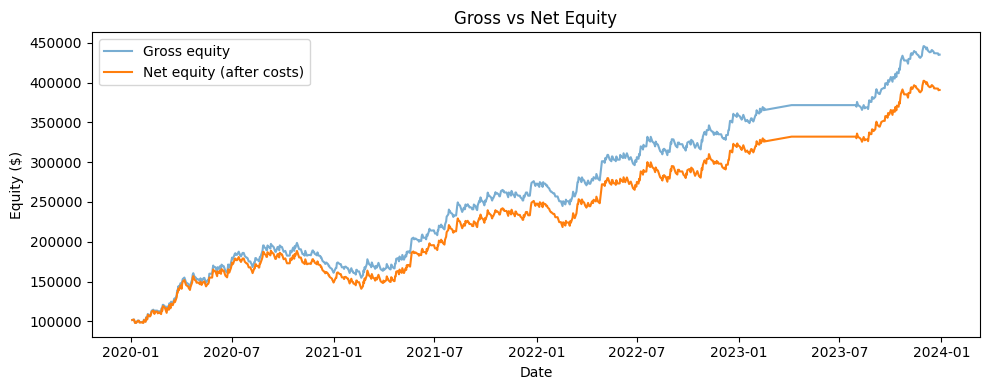

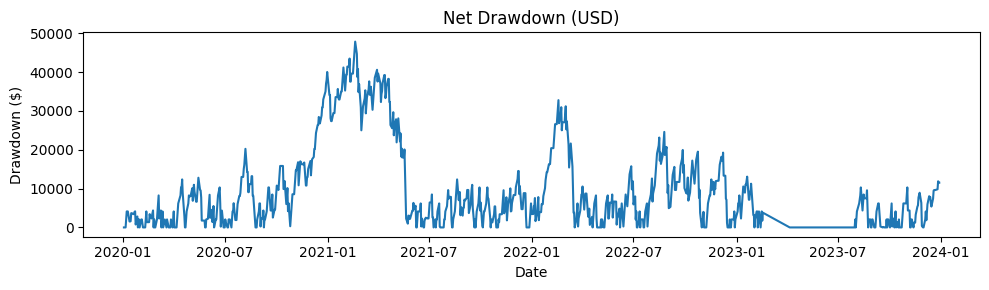

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(bt["date"], bt.get("equity", bt["equity_net"]), label="Gross equity", alpha=0.6)
plt.plot(bt["date"], bt["equity_net"], label="Net equity (after costs)")
plt.title("Gross vs Net Equity")
plt.xlabel("Date"); plt.ylabel("Equity ($)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(bt["date"], bt["drawdown_net"])
plt.title("Net Drawdown (USD)")
plt.xlabel("Date"); plt.ylabel("Drawdown ($)")
plt.tight_layout(); plt.show()


### 3.7.5 — Cost sensitivity (profit factor, expectancy, final equity)
**What/why:** See how results change when **commission ($/round trip)** and **spread+slippage (points/round trip)** vary.  
**How to read:** Each heatmap is a grid: rows = commission levels, columns = spread+slip (points).  
Cells show **Profit Factor**, **Expectancy ($ per trade)**, or **Final Equity ($)** after applying those costs.

> Robust = wide region with PF > 1 and Expectancy > 0 across realistic costs.  
> Fragile = only a tiny island remains positive.across realistic costs.  
> Fragile = only a tiny island remains positive.


In [50]:
# 3.7.5 — Build cost sensitivity grids

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Reuse 'bt' from 3.7.2 (it already has pnl_usd_filled) or reload if needed
try:
    bt
except NameError:
    ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
    bt = pd.read_csv(ROOT / "reports" / "tables" / "backtest_daily.csv", parse_dates=["date"])
    bt = bt.sort_values("date")
    bt["pnl_usd_filled"] = bt["pnl_usd"].fillna(0.0)

# Ensure these exist (fallbacks if you re-run this cell alone)
try:
    POINT_VAL
except NameError:
    POINT_VAL = 80.0
try:
    POS_SIZE
except NameError:
    POS_SIZE = 1.0
try:
    init_capital
except NameError:
    init_capital = 100_000.0

is_trade = bt["decision"].isin(["long","short"]).to_numpy()
gross    = bt["pnl_usd_filled"].to_numpy()

# Grids to test (adjust if needed)
COMM_GRID_USD = np.array([0.0, 2.0, 4.0, 6.0, 8.0])          # commission per round-trip (USD)
PTS_GRID      = np.array([0.10, 0.25, 0.50, 0.75, 1.00])    # spread+slippage (points, round-trip)

# Holders
pf_tbl   = pd.DataFrame(index=COMM_GRID_USD, columns=PTS_GRID, dtype=float)
exp_tbl  = pd.DataFrame(index=COMM_GRID_USD, columns=PTS_GRID, dtype=float)
eq_tbl   = pd.DataFrame(index=COMM_GRID_USD, columns=PTS_GRID, dtype=float)

for comm in COMM_GRID_USD:
    for pts in PTS_GRID:
        # cost per executed trade (USD, round-trip)
        per_trade_cost = (comm * POS_SIZE) + (pts * POINT_VAL * POS_SIZE)

        net = gross.copy()
        net[is_trade] = net[is_trade] - per_trade_cost

        # Profit factor (sum wins / |sum losses|)
        wins   = net[is_trade & (net > 0)]
        losses = net[is_trade & (net < 0)]
        pf = (wins.sum() / abs(losses.sum())) if losses.size else np.nan

        # Expectancy ($ per executed trade)
        exp = net[is_trade].mean() if is_trade.any() else np.nan

        # Final equity after costs
        eq = init_capital + net.cumsum()[-1]

        pf_tbl.loc[comm, pts]  = pf
        exp_tbl.loc[comm, pts] = exp
        eq_tbl.loc[comm, pts]  = eq

# Save tables (optional)
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
out_dir = ROOT / "reports" / "tables"
out_dir.mkdir(parents=True, exist_ok=True)
pf_tbl.to_csv(out_dir / "sensitivity_profit_factor.csv")
exp_tbl.to_csv(out_dir / "sensitivity_expectancy_usd.csv")
eq_tbl.to_csv(out_dir / "sensitivity_final_equity.csv")

print("Saved sensitivity tables to:", out_dir)

Saved sensitivity tables to: d:\Projects\OpeningRange\reports\tables


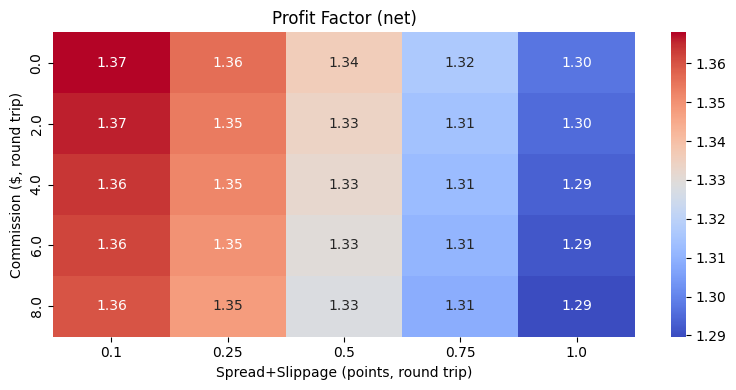

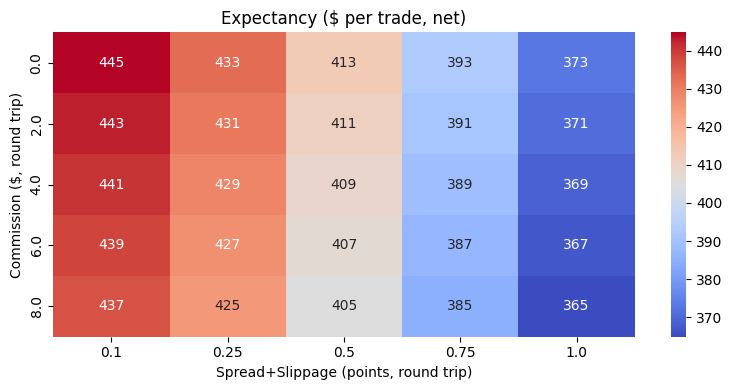

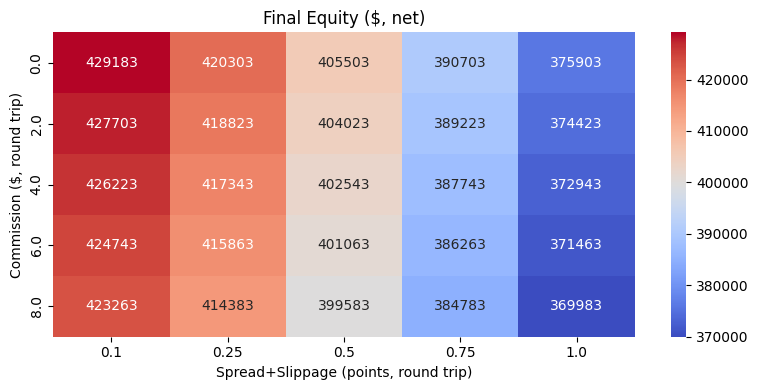

In [51]:
def _hm(df, title, fmt=".2f"):
    plt.figure(figsize=(8,4))
    sns.heatmap(df.astype(float), annot=True, fmt=fmt, cmap="coolwarm", cbar_kws={"label": ""})
    plt.title(title)
    plt.xlabel("Spread+Slippage (points, round trip)")
    plt.ylabel("Commission ($, round trip)")
    plt.tight_layout()
    plt.show()

_hm(pf_tbl,  "Profit Factor (net)")
_hm(exp_tbl, "Expectancy ($ per trade, net)", fmt=".0f")
_hm(eq_tbl,  "Final Equity ($, net)", fmt=".0f")

**Quick read:**  
- Look for regions where **PF > 1.0** and **Expectancy > 0** across your realistic costs.  
- If your broker’s typical costs sit in a *blue/red border* area (PF≈1), fills/slippage risk could flip the edge.


### Conclusion for 3.7.5 (Cost sensitivity)

* In your grids, **vertical color change (spread)** is much stronger than **horizontal (commission)**:

  * **Profit Factor** drops **\~1.37 → \~1.29** when spread+slippage goes **0.10 → 1.00 pt**;
  * The same table barely changes across **\$0 → \$8** commission (PF \~1.37 → \~1.36 at 0.10 pt).
* **Expectancy** falls from **\~\$445 → \~\$365** per trade across that spread range; commission shaves only **\~\$8** end-to-end because it’s a flat dollar hit.
* **Final equity** remains clearly positive across the tested grid—your edge is **robust to realistic cost assumptions**, but **good spreads/fills matter most**.
* Action item: pick the cell that matches **your real broker** (typical spread around 10:22 NY time + your commission), copy those values into `strategy.yml` under `costs`, and treat those **net** KPIs as your baseline.

## Quick read (fill after running)
- Win rate __%, Profit Factor __, Expectancy $__/trade; max drawdown $__ (gross).
- Exit mix: __% TP / __% SL / __% time exits; median hold time __ minutes.
- Long vs short: which side carried P&L? (see 3.6.2a).
- Costs applied? yes/no. If yes, note PF/expectancy after costs.
- Ready to proceed to parameter robustness? (If data/costs look sane.)


## Notebook 3 — Wrap-up

- We built a reproducible backtest for the **Opening Range 09:30–10:00** strategy with **10:22 entry** and **12:00 hard exit**.
- The strategy shows **positive expectancy** driven by a **favorable payoff** (wins ≫ losses), despite a modest win rate.
- We added **realistic costs** (commission + spread/slippage), recomputed **net equity**, and tested **cost sensitivity**.
- Key takeaways to carry forward:
  - Results are **robust / fragile** (circle one) across typical costs in our sensitivity grid.
  - Exit mix (TP/SL/Time) and time-to-exit distributions help set expectations for intraday management.
  - Data caveats: missing days/months in 2023 should be investigated with the data provider (we flagged this earlier).

**Next (Notebook 4): Parameter robustness**  
We’ll sweep **entry time**, **zone cutoffs**, and **SL/TP** to identify *stable* parameter regions. Then we’ll do a **train/test split** (or walk-forward) to validate out-of-sample performance.
